Download the support file for IS computation.

In [2]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [3]:
! unzip -q test_case_VAE.zip
! unzip -q test_case_GAN.zip

# VAE
### Load data for part 1.1 VAE


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

Extracting ./mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw


Extracting ./mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw


Extracting ./mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw




Extracting ./mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model Definition

In [5]:
class VAE(torch.nn.Module):
  def __init__(self, zdim=5, device='cpu'):
    super(VAE,self).__init__()
    ################################
    # Please fill in your code here:

    self.zdim = zdim
    self.device = device

    # encoder architecture
    self.fc1 = nn.Sequential(
        nn.Linear(in_features=784, out_features=400),
        nn.ReLU()
    )

    self.fc2_mean = nn.Sequential(
        nn.Linear(in_features=400, out_features=self.zdim),
        nn.ReLU()
    )

    self.fc2_var = nn.Sequential(
        nn.Linear(in_features=400, out_features=self.zdim),
        nn.ReLU()
    )

    # decoder architecture, FC3 and FC4
    self.decoder = nn.Sequential(
        nn.Linear(in_features=self.zdim, out_features=400),
        nn.ReLU(),
        nn.Linear(in_features=400, out_features=784),
        nn.Sigmoid()
    )

    ################################
    
    
  def encode(self, X):
    ################################
    # Please fill in your code here:

    h = self.fc1(X)
    mean = self.fc2_mean(h)
    log_var = self.fc2_var(h)

    ################################
    return mean, log_var

  def decode(self, X):
    ################################
    # Please fill in your code here:

    X = self.decoder(X)

    ################################
    return X

  def reparameterization(self, mean, log_var, eps=None):
    ################################
    # Please fill in std, eps and z:
    # std = exp(0.5*log_var)
    # eps = N(0,1)
    # z = mean + std * eps
    ################################

    std = torch.exp(0.5*log_var)
    if eps is None:
      eps = torch.normal(torch.zeros(mean.shape), torch.ones(mean.shape)).to(self.device)
    z = mean + std * eps

    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var



# reparameterization's output is dynamic, for the test case, we use a fixed eps 
# and all the intermediate result is provided. 
# You could use these values to check if you get the final output z correct.
# Or you could add eps to the input when testing the reparameterization module. 
# (warm reminder: don't forget to change back, cause the dynamic reparameterization is the key to VAE) 

vae_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_VAE = VAE(device=vae_device).to(vae_device)

# TEST YOUR REPARAMETRIZATION FUNCTION with the values below
testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt' )

z = net_VAE.reparameterization(testcase_mean, testcase_log_var, testcase_eps)
# print(testcase_z - z)


## VAE Train

### VAE Reconstruction Evaluation

---


For this reconstruction evaluation module, you need to integrate into training procesure.

In [6]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms: 
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE 
    '''
    # set model to eval
    ##################
    model.eval()
    ##################
    # Initialize MSE Loss(use reduction='sum')
    ##################
    mseloss = torch.nn.MSELoss(reduction='sum')
    ##################
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        # feed forward data to VAE
        ##################
        x_hat, _, _ = model.forward(data)
        ##################
        
        idx_counter+=data.shape[0] # sum up the number of images in test_loader

        # flatten the reconstruction output
        ##################
        data = data.view(-1, 784)
        ##################
        # accumulate the MSELoss acrossing the whole test set
        ##################
        recon_err = mseloss(data, x_hat)
        ##################
        
    avg_err = recon_err/idx_counter
    return avg_err




### Reconstruction error + KL divergence losses in VAE

In [7]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    '''
    Compute reconstruction loss and KL divergence loss mentioned in pdf handout
    '''
    ################################
    # Please compute BCE and KLD:

    x = x.view(-1, 784)

    bceloss = torch.nn.BCELoss(reduction='sum')
    BCE = bceloss(recon_x, x)
    KLD = 0.5*torch.sum(torch.exp(log_var) + mu ** 2 - torch.ones(mu.shape).cuda() - log_var)
    
    ################################
    totalloss = BCE + KLD

    return totalloss, BCE, KLD


#####################################################
# TEST CASE FOR VAE LOSS
#####################################################
testcase_loss_recon_x = torch.load('test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('test_case_VAE/loss_totalloss.pt')

loss, *_ = loss_function(testcase_loss_recon_x, testcase_loss_x, testcase_loss_mu, testcase_loss_log_var)
print("test case loss value:", testcase_loss_totalloss.item())
print("computed loss value:", loss.item())


test case loss value: 25477.3828125
computed loss value: 25477.3828125


### VAE Training

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 595.171523 	Recon_err: 1.2659523487091064
Train Epoch: 1 17% 	Loss: 319.298750 	Recon_err: 0.46473056077957153
Train Epoch: 1 33% 	Loss: 302.256465 	Recon_err: 0.3952871561050415
Train Epoch: 1 50% 	Loss: 300.410273 	Recon_err: 0.35006147623062134
Train Epoch: 1 67% 	Loss: 313.949824 	Recon_err: 0.3522009551525116
Train Epoch: 1 83% 	Loss: 303.628320 	Recon_err: 0.3384650945663452
Epoch: 1 Train loss: 318.7560
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 304.749902 	Recon_err: 0.318129301071167
Train Epoch: 2 17% 	Loss: 293.893301 	Recon_err: 0.3200947642326355
Train Epoch: 2 33% 	Loss: 291.022305 	Recon_err: 0.28781595826148987
Train Epoch: 2 50% 	Loss: 294.191133 	Recon_err: 0.28627723455429077
Train Epoch: 2 67% 	Loss: 300.168359 	Recon_err: 0.30595752596855164
Train Epoch: 2 83% 	Loss: 290.727656 	Recon_err: 0.280399352312088
Epoch: 2 Train loss: 292.5583
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 286.660820 	Recon_err: 0.2793553173

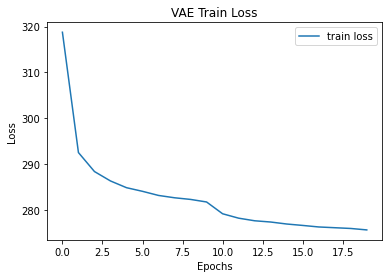

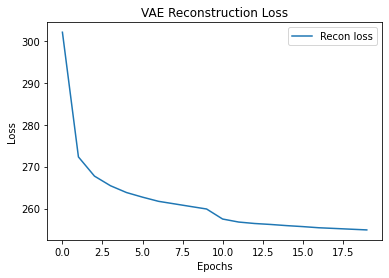

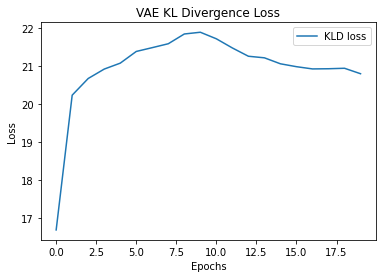

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 10000

#Initialize VAE
vae = VAE(ZDIM, device=device).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs 
num_epochs = 20
train_loss_list = []
BCE_loss_list = []
KLD_loss_lost = []

orig_image_list = []
recon_image_list = []
reconst_error = []


# Define Train loop 
def train(epochs, train_loader, test_loader):

  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      bce_loss = 0
      kld_loss = 0

      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae(data)

          loss, loss_bce, loss_kld = loss_function(recon_batch, data, mean, log_var)
          
          loss.backward()
          train_loss += loss.item()
          bce_loss += loss_bce.item()
          kld_loss += loss_kld.item()
          optimizer.step()

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          del data; del recon_batch; del mean; del log_var    
          
      train_loss_list.append(train_loss / len(train_loader.dataset))
      BCE_loss_list.append(bce_loss / len(train_loader.dataset))
      KLD_loss_lost.append(kld_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step() 

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():
          
            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot reconstruction loss
plt.title("VAE Reconstruction Loss")
plt.plot(BCE_loss_list,label="Recon loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot KLD loss
plt.title("VAE KL Divergence Loss")
plt.plot(KLD_loss_lost,label="KLD loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()






## Qualitative Visualisations

### VAE Testing

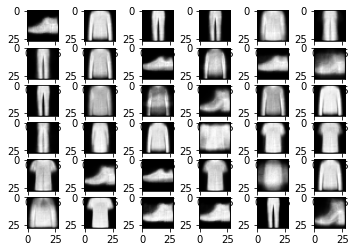

In [ ]:
# Test VAE on a random sample and display on 6X6 grid
grid_size = 6 

f, axarr = plt.subplots(grid_size, grid_size)

vae.eval()
for i, (data,_) in enumerate(test_loader):
    if i >= grid_size:
        break
    data = data.to(device)
    x_hat, _, _ = vae.forward(data)

    for j in range(grid_size):
        axarr[i, j].imshow(x_hat[j].cpu().detach().numpy().reshape(28,28), cmap='gray')



### Visualize the original vs reconstructed images

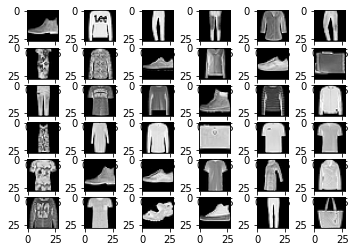

In [ ]:
# Visualise the original vs reconstructed images
# Input the 36 images in Fashion-MNIST to VAE network 
# and display reconstructed output on 6X6 grid

grid_size = 6 

f, axarr = plt.subplots(grid_size, grid_size)

for i, (data,_) in enumerate(test_loader):
    if i >= grid_size:
        break

    for j in range(grid_size):
        axarr[i, j].imshow(data[j].cpu().detach().numpy().reshape(28,28), cmap='gray')


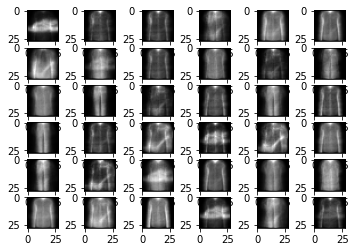

In [ ]:
grid_size = 6 

f, axarr = plt.subplots(grid_size, grid_size)

vae.eval()
for i in range(grid_size):
    for j in range(grid_size):
        data = torch.randn(ZDIM)
        data = data.to(device)
        x_hat = vae.decode(data)
        axarr[i, j].imshow(x_hat.cpu().detach().numpy().reshape(28,28), cmap='gray')


## Quantitative Evaluation

No handles with labels found to put in legend.


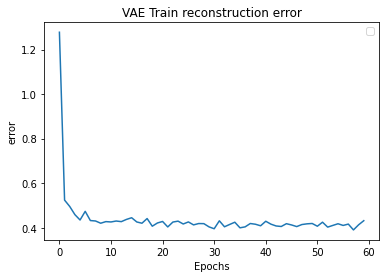

In [ ]:
# Please plot out the reconstruction error curve you saved 
# in 'reconstruction_error' list in training.
# And report the final reconstruction error value

# Plot Train loss
plt.title("VAE Train reconstruction error")
plt.plot(reconst_error)
plt.xlabel("Epochs")
plt.ylabel("error")
plt.legend()
plt.show()



### VAE IS score

The following block create 2 torch dataset.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_saved = torch.load('/content/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM)
model_vae.load_state_dict(model_saved['vae'])

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0]
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)
    
    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)

        
    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


#### Self-implement IS score (optional TODO)
This optional part is for implementing IS score computation following pdf instructions. You could also use the the next section "IS API" to compute the IS score.
For implementation, you would be asked to implement the most important part "compute_IS" function as an understanding of IS score computation.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            else:
                pred = image
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()
            
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
        del image
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''
    
    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table 
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)
    
    
    return IS_score
    


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_set, device, upsample = True)
gen_set_IS_score = IS(gen_set, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API
Here you could apply the existed API to compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



4.352345973620553
generated images IS_score:
2.0878333159159554


# GAN (please restart you colab session to refresh the GPU memory usage)
### Load data for part 2.1 GAN


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

Extracting ./stl10_data/stl10_binary.tar.gz to ./stl10_data/


## Model Definition

In [6]:
class DCGAN_Generator(nn.Module):
    def __init__(self, zdim=100):
        super(DCGAN_Generator,self).__init__()
        ################################
        # Please fill in your code here:
        # self.layer =  nn.Sequential()
        ################################

        self.zdim = zdim

        self.layer = nn.Sequential(
            # TransposedConv 1
            nn.ConvTranspose2d(in_channels=self.zdim, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            # TransposedConv 2
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # TransposedConv 3
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # TransposedConv 4
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # TransposedConv 5
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        

    def forward(self, input):
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        # self.layer =  nn.Sequential()
        ################################

        self.layer = nn.Sequential(
            # Conv 1
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Conv 2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Conv 3
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Conv 4
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Conv 5
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
    

    def forward(self, input):
        return self.layer(input).view(-1)

## GAN Training

### GAN loss

In [7]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):
    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    
    # return total loss_D and fake imagez

    # forward real images into the discriminator
    real_out = D.forward(real)
    # compute loss between Valid_label and discriminator output on real images
    loss_real = criterion(real_out, Valid_label)
    # forward noise into the generator
    # G.eval()
    # with torch.no_grad():
    fake = G.forward(noise)
    # forward fake images to the discriminator
    fake_out = D.forward(fake.detach())
    # print("fake_out in D:", fake_out)
    # Compute loss between Fake_label and discriminator output on fake images
    loss_fake = criterion(fake_out, Fake_label)
    # sum real loss and fake loss as the loss_D
    loss_D = loss_real + loss_fake

    return loss_D, fake

def loss_generator(netD, fake, Valid_label, criterion):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    #return loss_G

    # Forward fake images to the discriminator
    # netD.eval()
    fake_out = netD.forward(fake)
    # print("fake_out in G:", fake_out)
    # Compute loss between valid labels and discriminator output on fake images
    loss_G = criterion(fake_out, Valid_label)


    return loss_G

In [ ]:
fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
torch.save(loss_G, 'test_case_GAN/loss_G.pt')



test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())

test case loss_D: 1.382242202758789
computed loss_D: 1.382242202758789
test case loss_G: 0.69685298204422
computed loss_G: 0.69685298204422


### Training block

[0/100][0/40]	Loss_D: 1.3514	Loss_G: 1.0053	
[1/100][0/40]	Loss_D: 0.0449	Loss_G: 4.0752	
[2/100][0/40]	Loss_D: 0.7205	Loss_G: 3.1674	
[3/100][0/40]	Loss_D: 0.1328	Loss_G: 3.2520	
[4/100][0/40]	Loss_D: 0.0274	Loss_G: 5.0675	
[5/100][0/40]	Loss_D: 0.9266	Loss_G: 2.6842	
[6/100][0/40]	Loss_D: 0.8181	Loss_G: 1.9567	
[7/100][0/40]	Loss_D: 0.5862	Loss_G: 3.9371	
[8/100][0/40]	Loss_D: 0.8417	Loss_G: 4.4559	
[9/100][0/40]	Loss_D: 0.7863	Loss_G: 1.6062	
[10/100][0/40]	Loss_D: 0.9035	Loss_G: 3.6722	
[11/100][0/40]	Loss_D: 1.0001	Loss_G: 2.3537	
[12/100][0/40]	Loss_D: 1.6482	Loss_G: 3.2640	
[13/100][0/40]	Loss_D: 1.7930	Loss_G: 4.4482	
[14/100][0/40]	Loss_D: 0.9712	Loss_G: 2.4754	
[15/100][0/40]	Loss_D: 1.1497	Loss_G: 6.0995	
[16/100][0/40]	Loss_D: 0.5660	Loss_G: 4.5199	
[17/100][0/40]	Loss_D: 1.2013	Loss_G: 1.9989	
[18/100][0/40]	Loss_D: 0.9031	Loss_G: 2.8757	
[19/100][0/40]	Loss_D: 0.5755	Loss_G: 3.6595	
[20/100][0/40]	Loss_D: 0.8430	Loss_G: 4.3524	
[21/100][0/40]	Loss_D: 1.3783	Loss_G: 1.4012

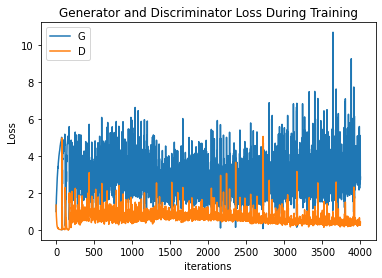

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

  
def load_param(num_eps):
    model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
    netG.load_state_dict(model_saved['netG'])
    netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.train()
        netD.zero_grad()
        # Function to compute discriminator loss
        # print("----------------------------calculating loss D----------------------------")
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)

        loss_D.backward()
        # Update D
        optimizerD.step()

        
        # torch.save(fake,'test_case_GAN/fake.pt')
        # torch.save(netD,'test_case_GAN/netD.pt')
        # torch.save(real,'test_case_GAN/real.pt')
        # torch.save(netG,'test_case_GAN/netG.pt')
        # torch.save(noise,'test_case_GAN/noise.pt')
        # torch.save(Valid_label,'test_case_GAN/Valid_label.pt')
        # torch.save(Fake_label,'test_case_GAN/Fake_label.pt')
        # torch.save(criterion,'test_case_GAN/criterion.pt')

        # pdb.set_trace()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.train()
        netG.zero_grad()
        # Function to compute generator loss
        # print("----------------------------calculating loss G----------------------------")
        loss_G = loss_generator(netD, fake, Valid_label, criterion)

        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    checkpoint = {'netG': netG.state_dict(),
                'netD': netD.state_dict()}
    torch.save(checkpoint, F"{HOMEWORK_FOLDER}/gan_"+str(epoch)+".pt")

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, '/content/gan_{}.pt'.format(num_epochs))


## Qualitative Visualisations

### GAN Testing (TODO)

In [1]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2020')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'GANs')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)


Mounted at /content/drive


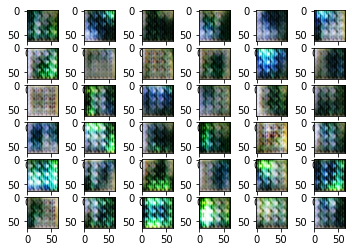

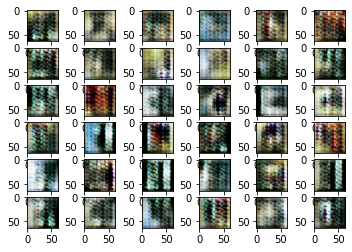

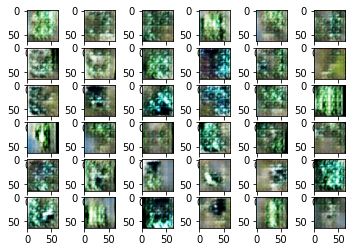

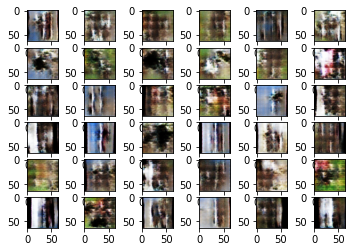

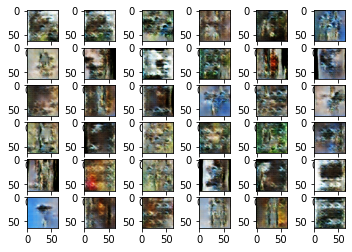

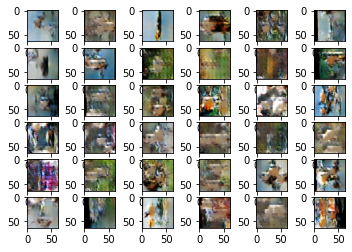

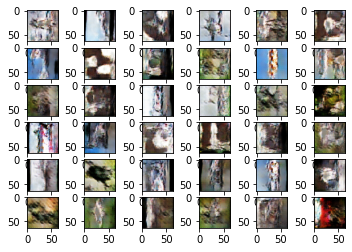

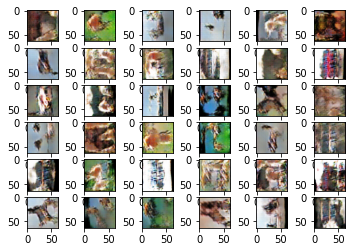

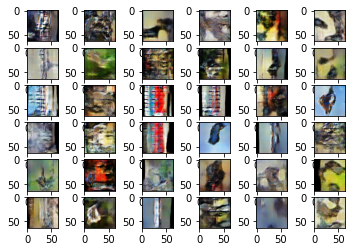

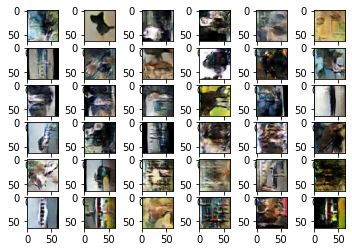

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test GAN on a random sample and display on 6X6 grid
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

for epoch in range(9, 100, 10):
    model_saved = torch.load(F"{HOMEWORK_FOLDER}/GAN/gan_"+str(epoch)+".pt")

    netG.load_state_dict(model_saved['netG'])
    netD.load_state_dict(model_saved['netD'])

    grid_size = 6 
    # Size of z latent vector (i.e. size of generator input)
    nz = 100

    f, axarr = plt.subplots(grid_size, grid_size)

    for i in range(grid_size):
        for j in range(grid_size):
            noise = torch.randn(1, nz, 1, 1, device=device)
            netG.eval()
            with torch.no_grad():
                fake = netG.forward(noise)
            pred_class = netD.forward(fake)
            # print(pred_class)
            out_img = (fake[0] + 1.0)/2.0
            out_img = torch.transpose(out_img, 0, 2)

            axarr[i, j].imshow(out_img.cpu().detach().numpy())
    plt.savefig(F"{HOMEWORK_FOLDER}/GAN/gan_visual_"+str(epoch)+".png")

### Visualisation at different epochs (TODO)

In [ ]:
# Plot GAN generated images at different epochs during training

# Size of z latent vector (i.e. size of generator input)
nz = 100
fixed_noise = torch.randn(36, nz, 1, 1, device=device)
model_saved = torch.load(F"{HOMEWORK_FOLDER}/GAN/gan_99.pt")

netG.load_state_dict(model_saved['netG'])

grid_size = 6 

f, axarr = plt.subplots(grid_size, grid_size)

for i in range(grid_size):
    for j in range(grid_size):
        noise = torch.randn(1, nz, 1, 1, device=device)
        netG.eval()
        with torch.no_grad():
            fake = netG.forward(noise)
        pred_class = netD.forward(fake)
        # print(pred_class)
        out_img = (fake[0] + 1.0)/2.0
        out_img = torch.transpose(out_img, 0, 2)

        axarr[i, j].imshow(out_img.cpu().detach().numpy())
plt.savefig(F"{HOMEWORK_FOLDER}/GAN/gan_visual_"+str(epoch)+".png")

## Quantitative Evaluation

In [10]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN
This part, you would be asked to compute a FID score between the real image and the generated images to evaluate the photo-realistic quality of the generated images. 
For this part, we should create three folder: 
- 1. STL_10_real_1 
- 2. STL_10_real_2 
- 3. STL_10_fake


In [13]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

Create the dataset to evaluate quantitative scores.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Load checkpoint
model_saved = torch.load(F"{HOMEWORK_FOLDER}/GAN/gan_99.pt")
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y



evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)
        
        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))


#### Self-implement FID score (optional TODO)
This optional part is for implementing FID score computation following pdf instructions. Implement "compute_FID" function which is the most important part in FID score computation. You could also use the the next section "FID API" to compute the FID score.

In [17]:
! pip install pytorch-fid
from pytorch_fid.inception import InceptionV3

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        
        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    
    return feature_table

def compute_stat(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    # print('dimension of mu', mu.shape)
    # print('dimension of sigma', sigma.shape)
    return mu, sigma


def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms: 
    Input:
        mu_1: mean vector we get for dataset1 
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2 
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''
    
    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy 
    # please name the resulting matrix as covmean

    # The following block take care of imagionary part of covmean 
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    # compute FID score, based on eqution.(10) in pdf FID part.
    

    return FID_score

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms: 
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table 
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)


    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)
    
    
    return FID_score


  Created wheel for pytorch-fid: filename=pytorch_fid-0.1.1-cp36-none-any.whl size=10188 sha256=bf4c695c578f72e6d570415f0a35217e372a428573549044e82c5389878d9a3e
  Stored in directory: /root/.cache/pip/wheels/b8/93/92/a6a8add9047b97dcb2470d2d1642450e6b76b5988e9744e3f0
Successfully built pytorch-fid


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute FID using FID function you implemented above
FID_score = FID(real_dataset_1, real_dataset_1, device)
print('FID_score between real_dataset_1 and itself:', FID_score)

FID_score = FID(real_dataset_1, real_dataset_2, device)
print('FID_score between real_dataset_1 and real_dataset_2:', FID_score)

FID_score = FID(real_dataset_1, gen_dataset, device)
print('FID_score between real_dataset_1 and generated image set:', FID_score)

#### FID API

In [22]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_1' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_2' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_fake' --gpu 0


100% 20/20 [00:01<00:00, 12.60it/s]
100% 20/20 [00:01<00:00, 12.36it/s]
FID:  -2.194161129409622e-05
100% 20/20 [00:01<00:00, 13.16it/s]
100% 20/20 [00:01<00:00, 12.25it/s]
FID:  37.67411979964908
100% 20/20 [00:01<00:00, 12.97it/s]
100% 20/20 [00:01<00:00, 11.87it/s]
FID:  206.88638045262212


If you implement the self-implement FID version. You would notice a negligible difference in value. Because the API package compute this value by saving and reading tensor from .png files. Accuracy problem could happen in the middle of transation.

### IS score for GAN

#### Self-implement IS score (optional)

You could copy and paste this function from VAE part if you have implement that part.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()
            
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms: 
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms: 
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''
    
    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table 
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)
    
    
    return IS_score
    


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_dataset_1, device, upsample = True)
gen_set_IS_score = IS(gen_dataset, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API

In [25]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for real data set 2:')
print(inception_score(real_dataset_2, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:
14.623428882365124
IS score for real data set 2:
15.913448906786716
IS score for generated data set:
2.3074932183545394
